# Week 13: Poly Square Mapping as a whole
Consider both boundary classification & distortion

## Table of Contents
- [0 - Packages](#0)
- [1 - Test Example](#1)
- [2 - The Loss Function](#2)
- [3 - Result](#3)
- [4 - Intuition of Angle Activation](#4)
- [5 - Problems](#5)
- [6 - Reference](#6)

<a name='0'></a>
## 0 - Package

In [1]:
# Packages
import numpy as np
import random
import matplotlib.pyplot as plt
from scipy.optimize import minimize
import torch
from torch.optim import LBFGS
torch.set_printoptions(precision=10)

# Self-defined functions
import sys
import os
sys.path.append(os.path.abspath(os.path.join('..')))
from util.util import distance_euclidean
from util.mesh.triangle.common import retrieve_boundary_edges, retrieve_all_edges, retrieve_boundary_vertices, retrieve_triangles_with_edge
from util.mesh.triangle.R2 import make_clockwise_2D, retrieve_boundary_angles_2D, retrieve_boundary_vertices_related_edges_2D, retrieve_boundary_edges_related_vertices_2D
from util.vector import vector_normalize, calculate_normal_2D, calculate_L1_norm
from util.derivative import derivative_euclidean_distance, derivative_inverse
from util.mesh.triangle.algorithm.R2.embedding_Tutte import Tutte_embedding_2D
from util.pyvista_util import preprocess, postprocess

from scipy.sparse import csr_matrix
from scipy.sparse.linalg import spsolve

# Visualization
import pyvista as pv
from pyvista import examples
import torch
import torch.optim as optim

from scipy.spatial import Delaunay

C:\Tool\Env\Anaconda3\lib\site-packages\paramiko\transport.py:219: CryptographyDeprecationWarning: Blowfish has been deprecated
  "class": algorithms.Blowfish,


<a name='1'></a>
## 1 - Test Example

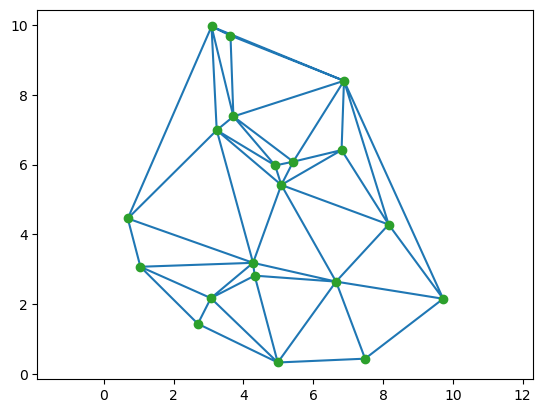

In [2]:
# 100 random points
v_num = 20
points = np.random.rand(v_num, 2)
points[:, 0]*=10
points[:, 1]*=10

# Delaunay algorithm to triangulate the mesh
tri = Delaunay(points)
make_clockwise_2D(points, tri.simplices)

faces=tri.simplices.copy()
vertices=points.copy()

plt.triplot(points[:,0], points[:,1], tri.simplices)
plt.plot(points[:,0], points[:,1], 'o')
plt.axis('equal')
plt.show()

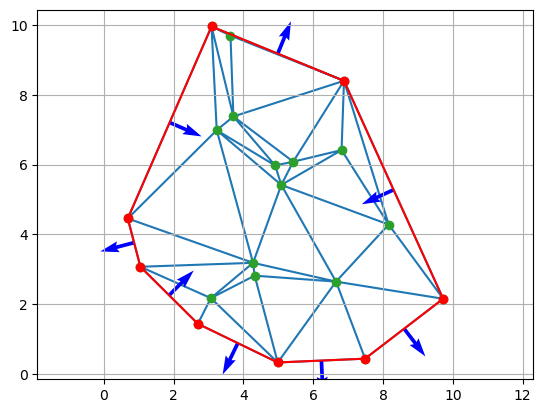

In [3]:
# edges = triangle_edges(tri.simplices)
boundary_vertices = retrieve_boundary_vertices(tri.simplices)
boundary_edges = retrieve_boundary_edges(tri.simplices)
boundary_angles = retrieve_boundary_angles_2D(boundary_edges, points)

boundary_normals = []
boundary_mid_points = []

for edge in boundary_edges:
    A = points[edge[0]]
    B = points[edge[1]]
    boundary_mid_points.append((A+B)/2)
    boundary_normals.append(calculate_normal_2D(A, B))

fig, ax = plt.subplots()
# Plot
plt.triplot(points[:,0], points[:,1], tri.simplices)
plt.plot(points[:,0], points[:,1], 'o')
for edge in boundary_edges:
    plt.plot(points[np.array(edge), 0], points[np.array(edge), 1], 'r-')
for idx in boundary_vertices:
    plt.plot(points[idx][0], points[idx][1], 'o', color='red',)
for idx, normal in enumerate(boundary_normals):
    plt.quiver(boundary_mid_points[idx][0], boundary_mid_points[idx][1], normal[0], normal[1], angles='xy', scale_units='xy', scale=1, color='blue')

# plt.plot(points[monitor_id][0], points[monitor_id][1], 'o', color='black')
plt.axis('equal')
plt.grid() 
plt.show()


## New test

In [4]:
class Chen_2023_scipy:
    def __init__(self, vertices, faces, lambda1=1, lambda2=1, max_iter = 100):
        self.max_iter = max_iter
        self.v_num = vertices.shape[0]
        self.vertices = vertices
        self.solution = self.vertices.copy()
        self.faces = faces
        self.J = []
        self.b = []
        
        # Hyper parameters
        self.lambda1=lambda1
        self.lambda2=lambda2
        
        # Boundary realated "BE = boundary edges" and "BV = boundary vertices"
        self.BE_r_V = retrieve_boundary_edges(faces)
        self.BV_r_V = retrieve_boundary_vertices(faces)
        self.BV_r_BV = retrieve_adjacent_vertices_with_boundary_vertex(self.BV_r_V, self.BE_r_V)
        self.BE_r_BV = retrieve_boundary_edges_related_vertices_2D(self.BV_r_V, self.BE_r_V)
        self.BV_num = len(self.BV_r_V)
    
    def activation(self, angle):
        if angle < (np.pi/2):
            return np.power(np.cos(angle), 2) / angle
        else:
            return np.power(np.sin(2*angle), 2)
        
    def objective(self, BV):
        BV = BV.reshape((self.BV_num,2))

        E_align = 0
        E_angle = 0
        
        for i, (v1, v2) in enumerate(self.BV_r_BV):
            edge1 = BV[v1] - BV[i]
            edge2 = BV[v2] - BV[i]
            
            L1 = np.linalg.norm(edge1)
            L2 = np.linalg.norm(edge2)
            
            cos_theta = np.dot(edge1, edge2) / (L1 * L2)
            angle = np.arccos(np.clip(cos_theta, -1.0, 1.0))
            
            E_angle += self.activation(angle)
            E_align += L1*(np.sum(np.absolute(edge1/L1)) - 1) + L2*(np.sum(np.absolute(edge2/L2)) - 1)
        
#         for edge in self.BE_r_BV:
#             A, B = BV[edge[0]], BV[edge[1]]
#             E_align += np.sum(np.absolute(B - A)) - distance_euclidean(A, B)

        return E_angle + E_align
    
    def mapping(self):
        self.solution = Tutte_embedding_2D(vertices, faces, self.solution[self.BV_r_V])
        
        for face in self.faces:
            A, B, C = self.solution[face]
            A_, B_, C_ = self.vertices[face]
            
            before = np.column_stack([B_-A_,C_-A_])
            after = np.column_stack([B-A,C-A])
            J_ = after @ np.linalg.inv(before)
            b_ = J_ @ B_ - B
            self.J.append(J_)
            self.b.append(b_)
            
    
    def optimize_default(self):
        x0 = np.ravel(self.solution[self.BV_r_V])
        self.res = minimize(self.objective, x0, options = {'maxiter': self.max_iter}, method = "BFGS")
        self.solution[self.BV_r_V] = self.res.x.reshape((len(self.BV_r_V) , 2))
    
    def optimize(self, iter_num):
        for i in range(iter_num):
            self.optimize_one_round()
            print("Round ", i, " done!")
    
    def optimize_one_round(self):
        x0 = np.ravel(self.solution[self.BV_r_V])
        self.res = minimize(self.objective, x0, options = {'maxiter': 1}, method = "BFGS")
        self.solution[self.BV_r_V] = self.res.x.reshape((len(self.BV_r_V) , 2))
        
    def v_plt(self, show_origin=False, show_BV=False, show_vertices=False, show_inner_edges=False, save_dict='', show_boundary_v=False):
#         plt.triplot(self.vertices[:,0], self.vertices[:,1], self.faces, label='Original Mesh', color='blue')
        if show_inner_edges:
            plt.triplot(self.solution[:,0], self.solution[:,1], self.faces, color='skyblue')
        if show_vertices:
            plt.plot(self.vertices[:,0], self.vertices[:,1], 'o')
        if show_BV:
            BV = self.solution[self.BV_r_V]
            plt.plot(BV[:,0], BV[:,1], 'o', color="green")
        if show_origin:
            for edge in self.BE_r_V:
                plt.plot(self.vertices[np.array(edge), 0], self.vertices[np.array(edge), 1], 'g-')
            plt.plot(self.vertices[np.array(self.BE_r_V[0]), 0], self.vertices[np.array(self.BE_r_V[0]), 1],label='Boundary before mapping', color='green')
            if show_inner_edges:
                plt.triplot(self.vertices[:,0], self.vertices[:,1], self.faces, color='greenyellow')
        for edge in self.BE_r_V:
            plt.plot(self.solution[np.array(edge), 0], self.solution[np.array(edge), 1], 'b-')
        plt.plot(self.solution[np.array(self.BE_r_V[0]), 0], self.solution[np.array(self.BE_r_V[0]), 1], label='Boundary after mapping', color='blue')
        if show_boundary_v:
            plt.plot(self.solution[self.BV_r_V,0], self.solution[self.BV_r_V,1], 'o')
        plt.axis('equal')
        plt.legend()
        if save_dict:
            plt.savefig(save_dict, dpi=300)
        plt.show()

In [5]:
def retrieve_adjacent_vertices_with_vertex(boundary_vertices, boundary_edges):
    adjacent = {v: set() for v in boundary_vertices}

    for edge in boundary_edges:
        v1, v2 = edge
        if v1 in adjacent:
            adjacent[v1].add(v2)
        if v2 in adjacent:
            adjacent[v2].add(v1)

    result = [list(adjacent[v]) for v in boundary_vertices]

    return result

def retrieve_adjacent_vertices_with_boundary_vertex(boundary_vertices, boundary_edges):
    adjacent = retrieve_adjacent_vertices_with_vertex(boundary_vertices, boundary_edges)
    result = [np.append(np.where(boundary_vertices==v1), np.where(boundary_vertices==v2)) for v1, v2 in adjacent]

    return np.array(result)

In [ ]:
tritess_v, tritess_f = preprocess("./mesh/tritess/tritess_input.ply")
tritess_test = Chen_2023_scipy(tritess_v, tritess_f)
tritess_test.optimize_default()
tritess_test.mapping()

In [ ]:
postprocess("./mesh/tritess/tritess_output.ply", tritess_test.solution, tritess_f)